<a href="https://colab.research.google.com/github/Teusner/Machine_Learning/blob/master/seafloorClassification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Programming Exercise 6: <ins>Supervised classification</ins>


## Objectifs


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:

<img src="https://raw.githubusercontent.com/Teusner/Machine_Learning/master/Seabed_Classification/dataset/patch.png" />


L'objectif est d'écrire des scripts permettant de mettre en \oe uvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des pixels
* évaluation du classifieur appris

<img src="https://raw.githubusercontent.com/Teusner/Machine_Learning/master/Seabed_Classification/dataset/imgs/Ripple vertical_Sure.00015.png" />

Le TP est globalement organisé de la manière suivante
* **Données**
 1. tout d'abord apprendre les modèles de classement (classifieurs) sur les données brutes (descripteurs=features=valeurs des pixels) 
 2. puis dans un second temps sur des descripteurs extraits à partir d'un algorithme appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à une banque de filtres mise en cascade). 

* **Prétraitements** Aucun prétraitement ne sera réalisé. 

* **Ensembles de données**
 1. Les ensembles de données seront composés de 1/3 de la base totale d'images. 
 2. Dans un second temps, nous procéderons par [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html) car la base d'images est de taille réduite.
* **Algorithmes** 
    Concernant les algorithmes supervisés de machine learning, l'objectif est d'utiliser les deux algorithmes de regression logistique et de réseaux de neurones que vous avez développés aux TP précédents et de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

* Pour commencer avec cette séance, vous aurez besoin de **télécharger** le _starter code_  disponible sur le lien Moodle du cours.

<span style='color:red'>**Dans cet exercice, il vous est demandé de fournir un rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un pdf ou d'un jupyter notebook. Il est de plus conseillé de faire tourner les codes sur google colab si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire).**</span>


## Fichiers inclus dans le starter code pour cette séance
* **pythonTools.py** - fonctions utiles pour l'affichage, le chargement des données et l'évaluation des performances
* **usefulCmds.py** - quelques commandes pour faciliter l'import des patchs
* **dataSet** - répertoire avec les images et les labels correspondants
* **dataSet\imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat** - fichier matlab contenant les descripteurs extraits des images par le scattering operator



# Part 0: intro

## 0.1 imports

First we need to import some usefull libraries in order to classify these seafloor sonar images.

In [3]:
# Dealing with system module and the current working directory
import sys
import os

# Data manipulation libraries
import numpy as np
import pandas as pd

# Scikit image manipulating and preprocessing functions to label our data
import skimage
from sklearn import preprocessing

Then we need to mount our working directory in order to get our dataset. Moreover we have to load some tools out of the _pythonTools_ module also available on my google drive.

In [4]:
# Testing if we are in google colab
IN_COLAB ='google.colab' in sys.modules

if IN_COLAB:
  # Mounting our drive folder
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # Changing the current working directory
  os.chdir("/content/gdrive/My Drive/Machine_Learning")
  
  # Importing a module from our drive folder
  from pythonTools import *

Mounted at /content/gdrive
None


## 0.2 Data analysing

This subsection is about the loading and the analyse of our dataset. The following tasks will be done :
* Loading the dataset available in _labels.csv_,
* Build a matrix containing the features of the images dataset
* Show a patch of data using _plot\_batch()_ available in _pythonTools.py_,

### 0.2.1 Dataset loading

To load the dataset, we first need to specify the path to the csv file which lists the different images and their labels. Then we are able to load this file in a _pandas_ dataframe named dataset_df.

In [5]:
# Loading the csv file
DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)

# We add another column to the labels dataset to identify image path
dataset_df['image_path'] = dataset_df.apply( lambda row: (DATASET_PATH + row["id"] ), axis=1)

**Question: What is the number of data, the number of features**

In [6]:
print(dataset_df)

                                 id  ...                                     image_path
0          Posidonia_Sure.00001.png  ...        ./dataset/imgs/Posidonia_Sure.00001.png
1          Posidonia_Sure.00002.png  ...        ./dataset/imgs/Posidonia_Sure.00002.png
2          Posidonia_Sure.00008.png  ...        ./dataset/imgs/Posidonia_Sure.00008.png
3          Posidonia_Sure.00011.png  ...        ./dataset/imgs/Posidonia_Sure.00011.png
4          Posidonia_Sure.00029.png  ...        ./dataset/imgs/Posidonia_Sure.00029.png
..                              ...  ...                                            ...
355  Ripple vertical_Sure.00562.png  ...  ./dataset/imgs/Ripple vertical_Sure.00562.png
356  Ripple vertical_Sure.00564.png  ...  ./dataset/imgs/Ripple vertical_Sure.00564.png
357  Ripple vertical_Sure.00669.png  ...  ./dataset/imgs/Ripple vertical_Sure.00669.png
358  Ripple vertical_Sure.00843.png  ...  ./dataset/imgs/Ripple vertical_Sure.00843.png
359  Ripple vertical_Sure.00855.

There is 360 different data in the provided database. We could also see that for each data there is an entry in this database to get the unique id of the data, and the path to the correspondig image.

In [10]:
n = 3
sample = dataset_df.sample(n)
sample_array = np.array([plt.imread(img) for img in sample['image_path'].values.tolist()])
for i in range(n):
  m, n = sample_array[i].shape[0], sample_array[i].shape[1]
  print("Image {0:<5} {1:<30} : size {2}x{3} ↦ {4} features".format(i+1, sample.iloc[i]["id"], m, n, m*n))

Image 1     Silt_Sure.03941.png            : size 200x200 ↦ 40000 features
Image 2     Ripple 45°_Sure.00018.png      : size 200x200 ↦ 40000 features
Image 3     Silt_Sure.00076.png            : size 200x200 ↦ 40000 features


We could see that each random picture out of this dataset is a 200x200 pixels sonar image, what makes 40 000 features for each data.

### 0.2.2 Shaping the dataset matrix

We need to load our data in a matrix in order to use it to train our model. Let's introduce the matrix X which will pack the dataset as follows :

$$
X = 
  \begin{bmatrix}
    X_1.T \\
    \vdots \\
    X_n.T
  \end{bmatrix}
$$

Where $X_1 \dots X_n$ are the column vector associated to each data in our dataset which represents the different features for each data. Each column vector has also a shape of (40000, 1) and the $X$ matrix has a shape of (360, 40000).

In [ ]:
# Loading the dataset in the X matrix
X = np.array([plt.imread(img).reshape(40000,) for img in dataset_df['image_path'].values.tolist()])

Then we need to get every unique labels out of our dataset. It will be usefull for our learning and our classification.

In [ ]:
# Getting labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique()

### 0.2.3 Dataset visualization

The following subsubsection is about data visualization. It's helpful to see a patch of random data out of our dataset. It let us check manually a subpart of the dataset, and to be able to check by hand the different classes available.

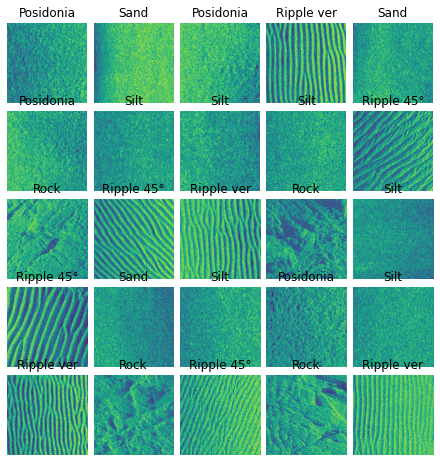

In [ ]:
# Getting 25 random data in our dataset
batch = load_batch(dataset_df)
# Showing a patch of these data
plot_batch(batch, 5, 5, 1, 1)

## 0.3 prétraitements des labels

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de disposer des labels dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms, indices, one-hot-encoding, etc.) 


_Your commented code below_

In [ ]:
# Labels encoding by index
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names_unique)

# Labels one-hot-encoding
label_ohe = pd.get_dummies(label_names.reset_index(drop=True)).values

# Getting labels for our dataset
y = le.transform(label_names)

## 0.4 Séparation des données en ensembles 

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de [normaliser](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin 
* de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) un pour l'apprentissage et un pour le test


_Your commented code below_

In [ ]:
# Separating our data in a training dataset and a testing dataset with a 1/3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(241, 40000) (241,) (119, 40000) (119,)


<strong>Question: Quel est le nombre de données totales et <ins>pour chaque classe</ins>, le nombres de descripteurs pour <ins>chaque ensemble de données</ins></strong>

On a 360 images qui forment nos 360 données permettant l'entrainement de notre modèle. Pour chaque classe on a vu que nous avons 60 données classifiées, possédants chacunes 40 000 descripteurs (features).

# Part 1 approches supervisées sur données brutes

<strong><ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?</strong> 

_votre réponse ici:_

In [ ]:
# Showing that our data doesn't have a 0 mean and a 1 standard deviation
print(np.mean(X[0]), np.std(X[0]))

0.22342825 0.013757655


On voit que la moyenne des descripteurs d'une donnée n'est pas 0 et l'écart type n'est pas de 1. Il est préférable d'avoir des données qui respectent ces caractéristiques, dans la mesure où cela nous permet de prendre des données provenant de différentes sources, et ensuite cela permet aussi de ne plus avoir à prendre en compte ces paramètres mathématiques lors de l'ajustement de courbe sur les données (par exemple les fonctions d'activations sont centrées autours de 0).

In [ ]:
# Computing the mean and the standard deviation of the training set
mean, std = np.mean(X_train, axis=1)[:, np.newaxis], np.std(X_train, axis=1)[:, np.newaxis]

# Normalizing the training set
X_train = (X_train - mean) / std

**<ins>Question</ins>: Nous allons apprendre les modèles suivants:
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones (solver=lbfgs), svm et random forest en utilisant les fonctions du package scikit-learn

Faire la liste des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment fixe-t-on leurs valeurs?**

_votre réponse ici:_ 

<strong><ins>Question</ins>: Fixez au mieux les valeurs des hyperparamètres, réalisez l'apprentissage des modèles suivants: 
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

_Your code below_

**<ins>Question</ins>: Évaluer les modèles appris en décrivant votre méthode**

_votre réponse ici:_

_Your code below_

**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)**

_Your image here_ <img src="https://github.com/Teusner/Machine_Learning/blob/master/Seabed_Classification/fichierDiagramme.png?raw=1" />

# Partie 2: Approche supervisée sur descripteurs issus du scattering operator

## Chargement des descripteurs

**<ins>Question</ins>: Chargez les données du fichier matlab imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat**

_Your Code below_

## Prétraitements

**<ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?**

_votre réponse ici:_ 

_Your Code below_

## Apprentissage

<strong><ins>Question</ins>: Séparer en deux ensembles de données et réalisez l'apprentissage successifs des modèles:
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

<span style='color:red'> **Pas de code à développer ici, réutiliser celui de la partie 1**</span>

_Your Code below_

## Fixer les hyper paramètres

**<ins>Question</ins>: Déterminez les hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment allez vous les fixer?**

_votre réponse ici:_

**<ins>Question</ins>:
Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html\#sphx-glr-auto-examples-applications-plot-face-recognition-py) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold).**

_Your Code below_

**<ins>Question</ins>: Évaluer les résultats et donner la valeur des paramètres optimaux**

_votre réponse ici:_

_Your Code below_

## Apprendre le modèle final pour chaque classifieur

_votre réponse ici:_

_Your Code below_

## Evaluer chaque classifieur

_votre réponse ici:_ 

_Your Code below_

## Partie 4 Analyse finale des résultats


**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation, les différents blocs de traitements.**

_votre réponse ici:_ 

_Your Code below_

**<ins>Question</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés et des prétraitements effectués.**

_votre réponse ici:_